# Fighting Crime with Art: Pittsburgh

## Leveraging the arts for community improvement

#### This project is the capstone for an IBM data specialization course. It serves to propose a location in Pittsburgh, Pennsylvania to create a work of public art. Data from Foursquare and Pittsburgh's Regional Data Center were leveraged to cluster Pittsburgh neighborhoods according to venue categories and crime rates. The optimal location for the art project was selected to maximize community accessibility in a relatively high-crime area.

## TOC:
* [Introduction](#first-bullet)
* [Data](#second-bullet)
* [Methodology](#third-bullet)
* [Results & Discussion](#fourth-bullet)
* [Conclusion](#fifth-bullet)

### Introduction <a class="anchor" id="first-bullet"></a>

#### The Iron City was once a smoggy, grey town built on the steel production industry. It is now home to a smattering of research universities, a thriving music and arts scence, and has recently been considered the most livable city in the United States. Although Pittsburgh is considered one of the safest U.S. cities with historically less crime compared to similar sized cities, there is room for improvement.

#### Evidence suggests that murals and public art lowers crime rates and increases local pride. Thus the aim of this project is to identify a high traffic area with a relatively higher crime rate. Installing a public art project in such a location allows for frequent interaction with the piece and has the greatest potential to positively impact the community.

#### The target audience includes urban planners and local Pittsburgh visual artists. Many organizations such as Pulse, and the Pittsburgh Cultural Trust are hard at work on projects with similar goals. Such groups can benefit from a data driven approach to optimizing their resources and their approach to positive transformation.

### Data <a class="anchor" id="second-bullet"></a>

#### Foursquare data are employed to obtain venue categories such as restaurants, parks, libraries, etc. A k-means clustering algorithm is used to group neighborhoods accoring to venue category. Concurrently, crime data from the Regional Data Center is utilized for the same process to cluster neighborhoods according to crime rate. Maps of the city are generated with the folium Python library and the venue clusters are analyzed in conjunction with the crime clusters to identify the highest leverage location for the art project. Descriptive statistics are also presented regarding prevalence of violent and non-violent crime in each neighborhood and crime rates for each cluster.

#### The Nominatim tool in the geopy Python package is utilized to retrieve location data for each neighborhood. First, an official list of neighborhoods from visitpittsburgh.com was used to manually create a spreadsheet for geocoding. The Foursquare API is called to cluster neighborhoods by venue category.

#### The crime data are imported from the Western Pennsylvania Regional Data Center, managed by the University of Pittsburgh in partnership with Allegheny County and the City of Pittsburgh. The selected dataset only contains information reported by City of Pittsburgh Police. It does not contain information about incidents that solely involve other police departments operating within the city (for example, campus police or Port Authority police). These data are are scraped from the spreadsheet into a pandas dataframe for descriptive statistical analysis and subsequent geocoding.

### Methodology <a class="anchor" id="third-bullet"></a>

#### This section contains the bulk of the code and all statistical analysis

In [1]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage for clustering the neighborhoods of Pittsburgh
from sklearn.cluster import KMeans

# Map rendering library for generating maps of Pittsburgh
import folium

# Libraries for data handling
import pandas as pd
import numpy as np

# For descriptive statistics
import seaborn as sns

# For retrieving geodata for Pittsburgh
import json

# For getting Foursquare data
import requests

# Geocoding tool to geocode Pittsburgh neighborhoods
from geopy.geocoders import Nominatim

print('Libraries imported.')

Libraries imported.


The csv file below was created in excel using an official list of 90 Pittsburgh neighborhoods from visitpittsburgh.com

In [2]:
pgh_hoods = pd.read_csv('https://raw.githubusercontent.com/cjcollin37/Coursera_Capstone/master/Pittsburgh%20Hoods.csv')
pgh_hoods.head()

,Neighborhood,Latitude,Longitude
0,Allegheny Center,NaN,NaN
1,Allegheny West,NaN,NaN
2,Allentown,NaN,NaN
3,Arlington,NaN,NaN
4,Arlington Heights,NaN,NaN


In [3]:
print('There are', (len(pgh_hoods['Neighborhood'])), 'neighborhoods in the dataset')

There are 90 neighborhoods in the dataset


The code below was used to geocode all neighborhoods. Since the geocoding process for a large quantity of neighborhoods can be inconsistent, the dataframe 'pgh_hoods' was exported as a csv file for all subsequent use rather than running the geocoding again each time. Furthermore, it was necessary to manually enter some missing coordinates using Google maps. The code is commented out to prevent it beginning again during development.

In [4]:
#neighborhoods = pgh_hoods['Neighborhood']
#hood_number = 0

#for hood in neighborhoods:
 #   geolocator = Nominatim(user_agent="cjcollin37@gmail.com")
  #  location = geolocator.geocode('{} Pittsburgh, Allegheny County, United States of America'.format(hood))
   # if location == None:
    #    pgh_hoods.loc[hood_number, 'Latitude'] = 'Nan'
     #   pgh_hoods.loc[hood_number, 'Longitude'] = 'Nan'
    #else:
     #   pgh_hoods.loc[hood_number, 'Latitude'] = location[1][0]
      #  pgh_hoods.loc[hood_number, 'Longitude'] = location[1][1]
    #hood_number = hood_number + 1

#pgh_hoods.head(10)

In [5]:
#pgh_hoods.to_csv('pgh_hoods.csv')

In [6]:
# The dataframe was exported in order to manually enter missing coordinates.

pgh_hoods = pd.read_csv('https://raw.githubusercontent.com/cjcollin37/Coursera_Capstone/master/pgh_hoods.csv')
pgh_hoods.head()

,Neighborhood,Latitude,Longitude
0,Allegheny Center,40.452937,-80.006344
1,Allegheny West,40.452273,-80.015741
2,Allentown,40.422618,-79.993086
3,Arlington,40.415179,-79.970018
4,Arlington Heights,40.416659,-79.962402


The coordinates of Pittsburgh were recorded here for later use in map generation with folium.

In [7]:
geolocator = Nominatim(user_agent="cjcollin37@gmail.com")

address = 'Pittsburgh, PA'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Pittsburgh are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Pittsburgh are 40.4416941, -79.9900861.


The map below employed folium to plot each neighborhood in Pittsburgh as a blue dot on the map.

In [8]:
# create map of Pittsburgh
pgh_map = folium.Map(location = [latitude, longitude], zoom_start = 11.5)

# add markers to map
for lat, lng, neighborhood in zip(pgh_hoods['Latitude'], pgh_hoods['Longitude'], pgh_hoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pgh_map)  
    
pgh_map

In [9]:
total_neighborhoods = len(pgh_hoods['Neighborhood'].unique())
print('The map above shows all', total_neighborhoods, 'neighborhoods in Pittsburgh.')

The map above shows all 89 neighborhoods in Pittsburgh.


After the neighborhoods were plotted, Foursquare data was retrieved using the credentials and function below. Only venue category information was analyzed to cluster the neighborhoods. The clusters represent groups of neighborhoods in Pittsburgh with similar types of venues (e.g. bars, restaurants, parks, etc).

In [10]:
CLIENT_ID = '0CNXP4CYHXWC3SUR3X0JIAPZJ3TFRAZO2DJAOQZ1SMTIALJ0' # Foursquare ID
CLIENT_SECRET = 'QULEUCZUSLATDTC5DPKDVJD0VKJITJFA342FSVRDNDQL4R2E' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [11]:
# Function to retrieve venues from the neighboorhoods - this was borrowed from a Coursera lab

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT = 100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# This executes the function above taking the Pittsburgh neighborhood coordinates dataframe as input to retrieve venue data

pgh_venues = getNearbyVenues(names = pgh_hoods['Neighborhood'],
                                   latitudes = pgh_hoods['Latitude'],
                                   longitudes = pgh_hoods['Longitude']
                                  )

Allegheny Center
Allegheny West
Allentown
Arlington
Arlington Heights
Banksville
Bedford Dwellings
Beechview
Beltzhoover
Bloomfield
Bluff
Bon Air
Brighton Heights
Brookline
California Kirkbride
Carrick
Central Lawrenceville
Central Northside
Central Oakland
Chartiers
Chateau
Crafton Heights
Crawford-Roberts
Downtown
Duquesne Heights
East Allegheny
East Carnegie
East Hills
East Liberty
Elliott
Esplen
Fairywood
Fineview
Friendship
Garfield
Glen Hazel
Greenfield
Hays
Hazelwood
Highland Park
Homewood North
Homewood South
Homewood West
Knoxville
Larimer
Lincoln-Lemington-Belmar
Lincoln Place
Lower Lawrenceville
Manchester
Marshall-Shadeland
Middle Hill
Morningside
Mount Oliver
Mount Washington
New Homestead
North Oakland
North Shore
Northview Heights
Oakwood
Overbrook
Perry North
Perry South
Point Breeze
Point Breeze North
Polish Hill
Regent Square
Ridgemont
Shadyside
Sheraden
South Oakland
South Shore
South Side Flats
South Side Slopes
Spring Garden
Spring Hill-City View
Squirrel Hill Nort

In [13]:
print(pgh_venues.shape)
pgh_venues.head()

(1067, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allegheny Center,40.452937,-80.006344,Children's Museum of Pittsburgh,40.452793,-80.006569,Museum
1,Allegheny Center,40.452937,-80.006344,Federal Galley,40.451605,-80.006045,Food Court
2,Allegheny Center,40.452937,-80.006344,El Burro,40.455860,-80.006689,Mexican Restaurant
3,Allegheny Center,40.452937,-80.006344,National Aviary,40.453154,-80.010049,Zoo
4,Allegheny Center,40.452937,-80.006344,Park House,40.453284,-80.001504,Bar


In [14]:
# Let's see how many unique categories there are

print('There are {} unique categories.'.format(len(pgh_venues['Venue Category'].unique())))

There are 218 unique categories.


In [15]:
# One hot encoding is useful for ranking venue categories by frequency for later clustering

pgh_onehot = pd.get_dummies(pgh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pgh_onehot['Neighborhood'] = pgh_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [pgh_onehot.columns[-1]] + list(pgh_onehot.columns[:-1])
pgh_onehot = pgh_onehot.reindex(columns =  fixed_columns)

pgh_onehot.head()

,Zoo,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Let's see how big this new dataframe is

pgh_onehot.shape

(1067, 218)

In [17]:
# Now we group by neighborhood, take mean frequency for each venue category for later clustering

pgh_grouped = pgh_onehot.groupby('Neighborhood').mean().reset_index()
pgh_grouped

,Neighborhood,Zoo,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Allegheny Center,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Allegheny West,0.041667,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Allentown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Arlington,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,Arlington Heights,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Banksville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,Bedford Dwellings,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Beechview,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,Bloomfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.023810,...,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,Bluff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [18]:
# Let's see how big this is

pgh_grouped.shape

(86, 218)

This shows the top 5 venue categories for the first 5 neighborhoods in the dataframe as a sample.

In [19]:
num_top_venues = 5

for hood in pgh_grouped['Neighborhood'].iloc[:5]:
    print("----"+hood+"----")
    temp = pgh_grouped[pgh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allegheny Center----
                venue  freq
0                Park  0.13
1             Exhibit  0.09
2       Deli / Bodega  0.09
3                 Zoo  0.04
4  Belgian Restaurant  0.04


----Allegheny West----
                  venue  freq
0   American Restaurant  0.08
1                   Pub  0.08
2        Sandwich Place  0.08
3  Fast Food Restaurant  0.08
4                   Zoo  0.04


----Allentown----
                           venue  freq
0                    Pizza Place   0.2
1                 Discount Store   0.2
2  Vegetarian / Vegan Restaurant   0.2
3                    Coffee Shop   0.2
4             Italian Restaurant   0.2


----Arlington----
                 venue  freq
0       Cosmetics Shop  0.33
1                  Bar  0.33
2  American Restaurant  0.33
3  Monument / Landmark  0.00
4        Moving Target  0.00


----Arlington Heights----
                 venue  freq
0  American Restaurant   0.5
1       Baseball Field   0.5
2                  Zoo   0.0
3    Outdo

This was entered into a dataframe below.

In [20]:
# First we need a function that sorts the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

The code below creates the dataframe using the function above and displays the top 10 venue categories for each neighborhood. These are the data used to cluster the neighborhoods.

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = pgh_grouped['Neighborhood']

for ind in np.arange(pgh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pgh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allegheny Center,Park,Deli / Bodega,Exhibit,Zoo,Bar,Performing Arts Venue,Coffee Shop,Event Space,Museum,Café
1,Allegheny West,Fast Food Restaurant,American Restaurant,Pub,Sandwich Place,Zoo,Coffee Shop,Pharmacy,Exhibit,Food Truck,Café
2,Allentown,Italian Restaurant,Pizza Place,Discount Store,Vegetarian / Vegan Restaurant,Coffee Shop,Yoga Studio,Farmers Market,Event Space,Exhibit,Farm
3,Arlington,Cosmetics Shop,American Restaurant,Bar,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
4,Arlington Heights,American Restaurant,Baseball Field,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


### Clustering the neighborhoods

A k-means clustering algorithm was used to group the neighborhoods into 3 clusters. This was found to be the most sensible number of clusters.

In [22]:
# set number of clusters
kclusters = 3

pgh_grouped_clustering = pgh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(pgh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 2, 0, 0, 1, 0, 0], dtype=int32)

This is a new dataframe that includes the cluster and top 10 venues for each neighborhood.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

pgh_merged = pgh_hoods

# merge pgh_grouped with pgh coordinate data (pgh_hoods) to add latitude/longitude for each neighborhood
pgh_merged = pgh_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

pgh_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allegheny Center,40.452937,-80.006344,0.0,Park,Deli / Bodega,Exhibit,Zoo,Bar,Performing Arts Venue,Coffee Shop,Event Space,Museum,Café
1,Allegheny West,40.452273,-80.015741,0.0,Fast Food Restaurant,American Restaurant,Pub,Sandwich Place,Zoo,Coffee Shop,Pharmacy,Exhibit,Food Truck,Café
2,Allentown,40.422618,-79.993086,0.0,Italian Restaurant,Pizza Place,Discount Store,Vegetarian / Vegan Restaurant,Coffee Shop,Yoga Studio,Farmers Market,Event Space,Exhibit,Farm
3,Arlington,40.415179,-79.970018,1.0,Cosmetics Shop,American Restaurant,Bar,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
4,Arlington Heights,40.416659,-79.962402,2.0,American Restaurant,Baseball Field,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


The cluster labels were converted to floats in the dataframe. Below they are converted back into integers (which is necessary for plotting).

Also, three neighborhood groups (Beltzhoover, Lincoln-Lemington-Belmar, New Homestead) have 'nan' values for cluster labels, and errors were found upon closer inspection. These three neighborhoods, along with St. Clair, were dropped from the study.

In [24]:
# Source of error not found, so let's drop these three neighborhoods. It is possible they have no listed venues.

pgh_merged.drop(index = 8, axis = 0, inplace = True)
pgh_merged.drop(index = 45, axis = 0, inplace = True)
pgh_merged.drop(index = 54, axis = 0, inplace = True)

# Check the new size
pgh_merged.shape

(86, 14)

In [25]:
# Change cluster labels to integers
pgh_merged['Cluster Labels'] = pgh_merged['Cluster Labels'].astype(int)
pgh_merged['Cluster Labels'].dtype

dtype('int64')

Finally, the clusters were visualized below using folium.

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.9, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pgh_merged['Latitude'], pgh_merged['Longitude'], pgh_merged['Neighborhood'], pgh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Pittsburgh Crime Data

#### The following data were obtained from the Western Pennsylvania Regional Data Center, managed by the University of Pittsburgh in partnership with Allegheny County and the City of Pittsburgh. It describes crime in Pittsburgh for the year of 2010. To simplify the analysis, only violent and property crimes were included. Aggravated assault, forcible rape, murder, and robbery are classified as violent while arson, burglary, larceny-theft, and motor vehicle theft are classified as property crimes. These crimes are collectively known as Index crimes; this name is used because the crimes are considered quite serious, tend to be reported more reliably than others, and are reported directly to the police and not to a separate agency. While this is likely a representative dataset to analyze crime, please note that it is not a full picture. It is limited to only the crimes described above, only reported crimes, and only in the year 2010.

#### The 'Crime Rate' column indicates the number of residents commiting crime per 100 residents. Each other column indicates the number of reported crimes for each category.

In [27]:
# The followind data were obtained from data.gov for crime in Pittsburgh in 2010
pgh_crime = pd.read_csv('https://raw.githubusercontent.com/cjcollin37/Coursera_Capstone/master/pgh_crime.csv')
pgh_crime.head()

,Neighborhood,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation
0,Allegheny Center,40.451577,-80.005340,7.6,0,2,9,5,8,5,31
1,Allegheny West,40.450784,-80.014403,8.2,1,0,4,6,6,4,12
2,Allentown,40.419192,-79.992731,6.4,0,2,15,23,48,11,66
3,Arlington,40.413833,-79.963270,2.7,0,1,8,5,15,7,9
4,Arlington Heights,40.416880,-79.961521,7.8,0,0,4,5,5,3,7


The data below are some quick, descriptive statistics showing the mean, standard deviation, minimum, quartiles, and maximum values for all neighborhoods in Pittsburgh.

An important note: South Shore and Chateau neighborhoods had outlier data points for crime rate, 145.5 and 194.7 respectively. They were both reduced to the maximum, 25 (Strip District), in order to properly visualize the data in the heat map displayed below.

In [28]:
pgh_crime.describe()

,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,40.443064,-79.980366,5.258889,0.511111,0.722222,11.533333,10.611111,29.444444,14.555556,26.388889
std,0.025441,0.049586,5.191326,0.950983,1.132044,13.042885,10.519852,26.731335,13.184185,25.197955
min,40.374528,-80.084781,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.425328,-80.010915,2.300000,0.000000,0.000000,2.000000,3.250000,8.000000,4.000000,7.250000
50%,40.449644,-79.986379,3.950000,0.000000,0.000000,7.000000,7.000000,21.000000,12.000000,18.500000
75%,40.459898,-79.947419,5.925000,1.000000,1.000000,16.000000,14.750000,44.500000,21.000000,39.750000
max,40.492217,-79.881722,25.200000,5.000000,6.000000,63.000000,61.000000,118.000000,59.000000,113.000000


In order to visualize the distrubution of crime within the city, a choropleth map, or 'heat map,' was created to show the crimes committed per 100 residents in each neighborhood ('Crime Rate' column of the dataframe).

In [29]:
# Initializes the map
crime_map = folium.Map(location=[latitude, longitude], zoom_start=11.5)

In [30]:
# This Pittsburgh geojson file outlines the neighborhoods, borrowed from David Blackman on Github
pgh_geo = r'https://raw.githubusercontent.com/blackmad/neighborhoods/master/pittsburgh.geojson'

crime_map.choropleth(
    geo_data=pgh_geo,
    data=pgh_crime,
    columns=['Neighborhood', 'Crime Rate'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.4,
    legend_name='Pittsburgh Crime Per Capita'
)

# display map
crime_map

/Users/collin/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The heat map displaying crime in the city was then overlayed with the clusters below.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.9, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pgh_merged['Latitude'], pgh_merged['Longitude'], pgh_merged['Neighborhood'], pgh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(crime_map)
       
crime_map

Finally, some further descriptive statistics were performed to analyze the crime rate for each cluster individually using boxplots.

In [32]:
# New dataframe that matches the pgh_merged dataframe (4 neighborhoods removed - St. Clair, Beltzhoover, Lincoln-Lemington-Belmar, New Homestead)
pgh_crime_merge = pd.read_csv('https://raw.githubusercontent.com/cjcollin37/Coursera_Capstone/master/pgh_crime_merge.csv')

pgh_crime_merge.head()

,Neighborhood,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation
0,Allegheny Center,40.451577,-80.005340,7.6,0,2,9,5,8,5,31
1,Allegheny West,40.450784,-80.014403,8.2,1,0,4,6,6,4,12
2,Allentown,40.419192,-79.992731,6.4,0,2,15,23,48,11,66
3,Arlington,40.413833,-79.963270,2.7,0,1,8,5,15,7,9
4,Arlington Heights,40.416880,-79.961521,7.8,0,0,4,5,5,3,7


In [33]:
# Add the cluster labels to the crimed dataframe
pgh_merged.reset_index(inplace = True, drop = True) # This ensures the indices match
pgh_crime_merge['Cluster Labels'] = pgh_merged['Cluster Labels']

pgh_crime_merge.head()

,Neighborhood,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation,Cluster Labels
0,Allegheny Center,40.451577,-80.005340,7.6,0,2,9,5,8,5,31,0
1,Allegheny West,40.450784,-80.014403,8.2,1,0,4,6,6,4,12,0
2,Allentown,40.419192,-79.992731,6.4,0,2,15,23,48,11,66,0
3,Arlington,40.413833,-79.963270,2.7,0,1,8,5,15,7,9,1
4,Arlington Heights,40.416880,-79.961521,7.8,0,0,4,5,5,3,7,2


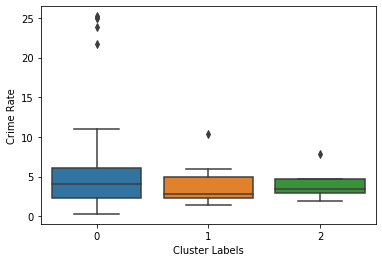

In [34]:
sns.boxplot(x = 'Cluster Labels', y = 'Crime Rate', data = pgh_crime_merge)

### Results & Discussion <a class="anchor" id="fourth-bullet"></a>

Let's dive a little deeper into these clusters. By obeserving the most common venue categories for each, we can better understand the characteristics, personality, and ultimately the amount of foot and road traffic for each.

In [35]:
pgh_merged.loc[pgh_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allegheny Center,40.452937,-80.006344,0,Park,Deli / Bodega,Exhibit,Zoo,Bar,Performing Arts Venue,Coffee Shop,Event Space,Museum,Café
1,Allegheny West,40.452273,-80.015741,0,Fast Food Restaurant,American Restaurant,Pub,Sandwich Place,Zoo,Coffee Shop,Pharmacy,Exhibit,Food Truck,Café
2,Allentown,40.422618,-79.993086,0,Italian Restaurant,Pizza Place,Discount Store,Vegetarian / Vegan Restaurant,Coffee Shop,Yoga Studio,Farmers Market,Event Space,Exhibit,Farm
5,Banksville,40.410690,-80.038643,0,Park,Yoga Studio,Electronics Store,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
6,Bedford Dwellings,40.450500,-79.974560,0,Men's Store,Home Service,Gym / Fitness Center,Field,Coffee Shop,Park,Ethiopian Restaurant,Food,Flower Shop,Fish Market
8,Bloomfield,40.461758,-79.949550,0,Bar,Japanese Restaurant,Bookstore,Sandwich Place,New American Restaurant,Grocery Store,Coffee Shop,Bakery,Thai Restaurant,Pizza Place
9,Bluff,40.436459,-79.984460,0,Pizza Place,Rental Car Location,Bar,Snack Place,Food Court,Shop & Service,Gas Station,Chinese Restaurant,Spa,Grocery Store
10,Bon Air,40.407259,-80.000737,0,Home Service,Playground,Light Rail Station,Yoga Studio,Electronics Store,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
11,Brighton Heights,40.477847,-80.035888,0,Sports Bar,Pizza Place,Bookstore,Park,Yoga Studio,Ethiopian Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field
13,California Kirkbride,40.462013,-80.024776,0,Bakery,Home Service,Electronics Store,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


#### Cluster 0 is by far the largest cluster. It is not surprising that, as a result, it appears to have the most varied venue categories from tea rooms to breweries, paintball fields to scenic lookouts, and Greek restaurants to sports bars. Compare this to the other clusters, all of which share far more similarities in their most common venue categories. That said, the most common venues in cluster 3 are generally food and drink related - an assortment of restaurant styles, cafes, and bars.

In [36]:
pgh_merged.loc[pgh_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Arlington,40.415179,-79.970018,1,Cosmetics Shop,American Restaurant,Bar,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
7,Beechview,40.410625,-80.024776,1,Light Rail Station,Spa,Supermarket,Farmers Market,Taco Place,Bar,Yoga Studio,Flower Shop,Fish Market,Fish & Chips Shop
12,Brookline,40.395740,-80.014226,1,Bar,Lounge,Mediterranean Restaurant,Convenience Store,Sports Bar,Karaoke Bar,Shopping Mall,Flower Shop,Fish Market,Fish & Chips Shop
20,Crafton Heights,40.444499,-80.051453,1,American Restaurant,Donut Shop,Bar,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field
39,Homewood North,40.458785,-79.890073,1,Bar,Concert Hall,Music Venue,Yoga Studio,Event Space,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field
40,Homewood South,40.453434,-79.892872,1,Food,Bank,Music Store,Music Venue,Café,BBQ Joint,Bar,Flower Shop,Fish Market,Fish & Chips Shop
47,Marshall-Shadeland,40.470347,-80.033388,1,Bar,Café,Cocktail Bar,Dog Run,Yoga Studio,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field
50,Mount Oliver,40.411047,-79.979312,1,Moving Target,Bar,Yoga Studio,Food Court,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
54,Northview Heights,40.478402,-80.000609,1,Construction & Landscaping,Bar,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
55,Oakwood,40.426590,-80.066666,1,Playground,Diner,Bar,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field


#### Cluster 1 is characterized by neighborhoods with the highest representation of bars among their venues. Overall, it seems to host venues mostly related to food and nightlife - bars, restaurants, markets - with some entertainment and health venues like rec centers, music venues, and gyms.

In [37]:
pgh_merged.loc[pgh_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Arlington Heights,40.416659,-79.962402,2,American Restaurant,Baseball Field,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
18,Chartiers,40.458012,-80.070694,2,Baseball Field,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
37,Hazelwood,40.413166,-79.939163,2,Baseball Field,Yoga Studio,Ethiopian Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
46,Manchester,40.455202,-80.024341,2,Storage Facility,Baseball Field,Yoga Studio,Food Court,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


#### All neighborhoods in cluster 2 share a striking similarity of hosting baseball fields, yoga studios, Ethiopian restaurants, flower shops, and flea and fish markets.

#### The results indicate that the most crime is committed in the center of the city - Downtown (Central Business District), Southshore, Northshore, Chateau, and the Strip District. These are all Cluster 0 neighborhoods. The boxplot (copied below) also demonstrates that the most crime per capita is committed in Cluster 0. Note that this measure is the number of crimes committed per 100 residents, and so the representation does not reflect a bias due to Cluster 0 being the largest.

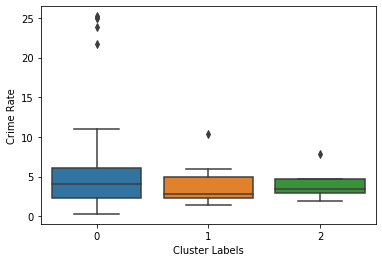

In [38]:
sns.boxplot(x = 'Cluster Labels', y = 'Crime Rate', data = pgh_crime_merge)

#### Upon closer inspection of the types of venues in the neighborhoods with the most crime, it is evident that these neighborhoods do not contain as many permanent residents as most other neighborhoods. Rather they are characterized by a more transient population and tourism with venues like hotels, stadiums, baseball fields, etc. Furthermore, the types of crimes committed in these areas (shown below) suggest that they may not be committed by the residents themselves. For example, robberies and burglaries make up the majority of the crimes in the downtown area. Downtown is an expensive area to live and does not host many permanent residents. Those commiting robberies and burglaries are likely not living downtown.

#### Community art projects in such areas may be low impact. It is suggested that community art is linked with reducing crime in some cities by instilling in the residents a sense of pride of their neighborhood. It is crucial that local residents themselves are involved in the project to make their home beautiful. Therefore, public art is likely a low leverage solution to reducing crime in neighborhoods with high tourism.

In [39]:
pgh_crime_merge.loc[(pgh_crime_merge['Neighborhood'] == 'Chateau') |
                   (pgh_crime_merge['Neighborhood'] == 'Downtown') |
                   (pgh_crime_merge['Neighborhood'] == 'South Shore') |
                   (pgh_crime_merge['Neighborhood'] == 'North Shore') |
                   (pgh_crime_merge['Neighborhood'] == 'Strip District')]

,Neighborhood,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation,Cluster Labels
19,Chateau,40.451815,-80.028051,25.0,0,0,1,0,0,2,14,0
22,Downtown,40.440678,-79.989212,21.7,0,4,55,27,66,20,66,0
53,North Shore,40.449658,-79.998110,23.8,0,0,1,6,7,5,8,0
67,South Shore,40.436629,-80.010270,25.0,0,0,4,1,5,2,3,0
75,Strip District,40.454500,-79.981276,25.2,0,0,12,14,20,18,38,0


#### There are several other better candidates in the Cluster 0 in the surrounding areas such as Bloomfield, East Allegheny, Larimer, Garfield, and many, many more. Two Cluster 1 neighborhoods - Homewood North and Homewood South - may potentially be the highest leverage neighborhoods to invest in a community art project. Both have relatively higher crime rates, as seen below. There is a variety of crimes, and both neighborhoods are far from the city center. It therefore seems likely that a higher percentage of all crimes are committed by residents, unlike the neighborhoods closer to city center discussed above. A community art project may therefore serve to reduce crime committed by locals.

In [40]:
pgh_crime_merge.loc[(pgh_crime_merge['Neighborhood'] == 'Homewood North') |
                   (pgh_crime_merge['Neighborhood'] == 'Homewood South')]

,Neighborhood,Latitude,Longitude,Crime Rate,Murder,Rape,Robbery,Assault,Burglary,Auto Theft,Drug Violation,Cluster Labels
39,Homewood North,40.459477,-79.895590,6.0,3,3,14,33,68,24,23,1
40,Homewood South,40.449689,-79.885978,10.4,4,0,38,25,74,30,50,1


#### Furthermore, it seems that both neighborhoods may already have a relationship with the arts as evidenced by the top three most common venues for each shown below (bars, concert halls, music stores, and music venues). They may be more receptive to a community art project. Also, the high occurrence of bars in each neighborhoods may lead to more frequent interaction and contact with the art if there is more foot and automobile traffic. This satisfies one of the major criterion laid out in the introduction.

In [41]:
num_top_venues = 3

for hood in pgh_grouped['Neighborhood'].iloc[39:41]:
    print("----"+hood+"----")
    temp = pgh_grouped[pgh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Homewood North----
          venue  freq
0           Bar  0.50
1  Concert Hall  0.25
2   Music Venue  0.25


----Homewood South----
         venue  freq
0          Bar  0.14
1  Music Store  0.14
2  Music Venue  0.14




### Conclusion <a class="anchor" id="fifth-bullet"></a>

#### The aim of this proposal is to identify the optimal neighborhood in Pittsburgh, PA to invest in a community art project with the aim of reducing crime. The key criteria are high crime rate per capita, and the potential for frequent interaction with the public art piece. A k-means clustering algorithm was employed in conjuction with Foursquare data in order to group all the neighborhoods into 3 clusters based on venue categories. Crime data from 2010 were used to generate a heat map of crime per capita in Pittsburgh. The two maps were analyzed and it was found that the highest occurrence of crime is in Cluster 0 - the largest cluster for which there is too much variability in venue category to discern any sensible characteristics. While the highest crime rates were found to occur close to city center, these Cluster 0 neighborhoods were deemed poor candidates for the project given the transient nature of their population. Two neighborhoods - Homewood North and Homewood South - were identified as the optimal candidates. These neighborhoods belong to Cluster 1, characterized primarily by bars, restuarants, and entertainment. They are also home to many music venues and stores suggesting a potential receptiveness to a public art project. Homewood South is the single most ideal candidate, given its higher crime rate per capita of 10.4%.

#### It is important to note that this proposal has many limitations. First, it was completed as part of the IBM Applied Data Science Specialization offered through Coursera. Second, four neighborhoods were excluded from the analysis for various reasons centered on lack of access to reliable data: St. Clair, Beltzhoover, Lincoln-Lemington-Belmar, and New Homestead. Third, the crime heat map only reflects reported crimes in 2010. Fourth, as mentioned before, South Shore and Chateau neighborhoods had anomalously high reported crime rate rates, and were lowered to the maximum of 25% for ease of visualization. Finally, many assumptions were made regarding the behavior of residents and criminals as well as the number of permanent residents in various neighborhoods. These assumptions are not based on research, they are instead interpretations of the data informed by the experience of a previous 6-year Pittsburgh resident.